# Instalando a biblioteca do CatBoost

In [ ]:
!pip install catboost

#Importando as bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from imblearn.under_sampling import NearMiss
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
import plotly.express as px

# Importando o Dataset

In [ ]:
df = pd.read_csv('star_classification.csv')
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [ ]:
df.shape

(100000, 18)

# Exploração dos dados

## Verificando o balanceamento dos dados

Primeiro vamos verificar o balanceamento dos dados das classes alvo, que são Estrelas, Quasares ou Galáxias para verificar se os dados estão muito desbalanceados, e caso estejam, precisaremos balancear os dados para evitar que o modelo de ML tenha perdas de desempenho.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



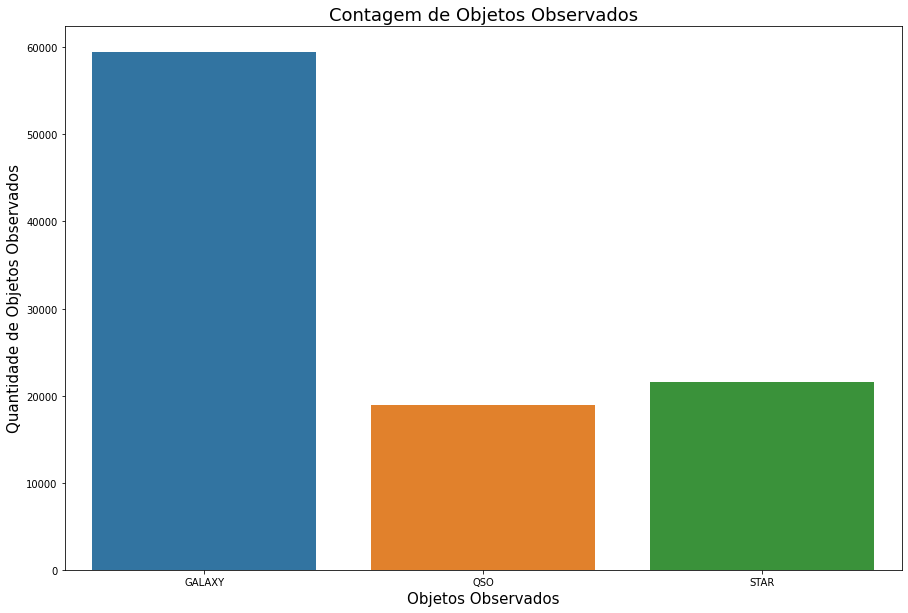

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(df['class'])
plt.xlabel('Objetos Observados', fontsize=15)
plt.ylabel('Quantidade de Objetos Observados', fontsize=15)
plt.title('Contagem de Objetos Observados', fontsize=18)
plt.show()

In [ ]:
np.unique(df['class'], return_counts=True)

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([59445, 18961, 21594]))

Podemos ver que temos dados muito desbalanceados, já que temos muito mais ocorrências de galáxias do que de Quasares e Estrelas. Faremos o balanceamento dos dados mais à frente.

## Verificando se há dados nulos

Precisamos verificar se há dados nulos em nosso dataset, e caso haja, verificaremos qual a melhor maneira de tratar esses dados.

In [ ]:
df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

Podemos ver que o dataset não possui dados nulos, assim não precisaremos fazer qualquer tipo de correção.

## Verificando o tipo dos dados

In [ ]:
df.dtypes

obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class           object
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object

Podemos verificar que assim como apresentado no dataset, todos os dados são do tipo int ou float, com excessão da nossa classe alvo. Assim não precisaremos fazer qualquer tipo de alteração nos tipos de dados.

In [ ]:
np.unique(df.run_ID, return_counts=True)

(array([ 109,  211,  273,  287,  297,  307,  308,  745,  752,  756,  994,
        1000, 1035, 1037, 1043, 1045, 1140, 1231, 1239, 1241, 1302, 1331,
        1336, 1339, 1345, 1350, 1356, 1402, 1404, 1411, 1412, 1450, 1453,
        1458, 1462, 1473, 1478, 1729, 1737, 1738, 1739, 1740, 1749, 1754,
        1755, 1854, 1855, 1862, 1869, 1889, 1896, 1897, 1904, 1907, 1992,
        2065, 2074, 2076, 2078, 2125, 2126, 2127, 2137, 2187, 2188, 2190,
        2194, 2206, 2207, 2243, 2247, 2248, 2259, 2299, 2304, 2305, 2326,
        2327, 2328, 2333, 2334, 2335, 2346, 2348, 2379, 2391, 2392, 2507,
        2566, 2574, 2583, 2659, 2662, 2677, 2700, 2711, 2728, 2777, 2820,
        2821, 2822, 2825, 2826, 2830, 2831, 2863, 2864, 2882, 2883, 2888,
        2960, 2961, 2963, 2964, 2968, 2986, 2987, 2989, 3015, 3031, 3058,
        3059, 3103, 3177, 3180, 3184, 3185, 3187, 3225, 3226, 3230, 3356,
        3358, 3366, 3367, 3434, 3438, 3461, 3462, 3478, 3512, 3525, 3530,
        3557, 3559, 3560, 3562, 3600, 

In [ ]:
np.unique(df.rerun_ID, return_counts=True)

(array([301]), array([100000]))

# Tratamento dos dados

Precisaremos retirar da nossa base dados que não contribuem para o modelo, já que por exemplo o "obj_ID" trata-se somente de uma variável  descrevendo o ID do objeto observado, não fazendo qualquer diferença para o resultado final. No campo abaixo deixo o disclamer com o que cada variável no dataset representa: 

1.	obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS. (Identificador de objeto, o valor exclusivo que identifica o objeto no catálogo de imagens usado pelo CAS.).

2.	alpha = Right Ascension angle (at J2000 epoch). (Ângulo de Ascensão Reta (na época J2000)).

3.	delta = Declination angle (at J2000 epoch). (Ângulo de declinação (na época J2000)).

4.	u = Ultraviolet filter in the photometric system. (Filtro ultravioleta no sistema fotométrico).

5.	g = Green filter in the photometric system. (Filtro verde no sistema fotométrico).

6.	r = Red filter in the photometric system
7.	i = Near Infrared filter in the photometric system
8.	z = Infrared filter in the photometric system
9.	run_ID = Run Number used to identify the specific scan
10.	rereun_ID = Rerun Number to specify how the image was processed
11.	cam_col = Camera column to identify the scanline within the run
12.	field_ID = Field number to identify each field
13.	spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14.	class = object class (galaxy, star or quasar object)
15.	redshift = redshift value based on the increase in wavelength
16.	plate = plate ID, identifies each plate in SDSS
17.	MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18.	fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

Vamos remover aquelas colunas que se tratam de IDS, ou seja, colunas que apenas identificam objetos e que não interferem no resultado final.

In [ ]:
df.drop(['obj_ID', 'rerun_ID', 'MJD', 'plate', 'run_ID', 'field_ID', 'spec_obj_ID', 'fiber_ID'], axis=1, inplace=True)
df

,alpha,delta,u,g,r,i,z,cam_col,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,GALAXY,0.116123
...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,2,GALAXY,0.000000
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,1,GALAXY,0.404895
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,4,GALAXY,0.143366
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,4,GALAXY,0.455040


Por questões de prática, vou reordenar as colunas para facilitar o processo de separação entre previsores e classes já convertendo em arrays com a técnica do iloc

In [ ]:
lista = list(df.columns)
lista

['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'class', 'redshift']

In [ ]:
df = df[['class','alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'redshift']]
df.head()

,class,alpha,delta,u,g,r,i,z,cam_col,redshift
0,GALAXY,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,0.634794
1,GALAXY,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,0.779136
2,GALAXY,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,0.644195
3,GALAXY,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,0.932346
4,GALAXY,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,0.116123


## Encoding da variável classes

Precisamos transformar a variável resposta "Class" em variáveis numéricas, uma vez que muitos algoritmos de ML não reconhecem variáveis categóricas. Pare isso utilizaremos o método do LabelEncoder da biblioteca do Sklearn.

In [ ]:
encoder = LabelEncoder()

In [ ]:
df['class_encoded'] = encoder.fit_transform(df['class'])
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,class,alpha,delta,u,g,r,i,z,cam_col,redshift,class_encoded
0,GALAXY,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,0.634794,0
1,GALAXY,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,0.779136,0
2,GALAXY,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,0.644195,0
3,GALAXY,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,0.932346,0
4,GALAXY,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,0.116123,0


In [ ]:
novo = df.groupby('class')['class_encoded'].unique()
novo

class
GALAXY    [0]
QSO       [1]
STAR      [2]
Name: class_encoded, dtype: object

In [ ]:
np.unique(df['class'])

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

Como vemos, as variáveis categóricas foram convertidas em variáveis numéricas.

In [ ]:
filtro_quasar = df['class']=='QSO'
novo_quasar = df[filtro_quasar]
novo_quasar

,class,alpha,delta,u,g,r,i,z,cam_col,redshift,class_encoded
5,QSO,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,3,1.424659,1
6,QSO,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,2,0.586455,1
17,QSO,1.494389,3.291746,20.38562,20.40514,20.29996,20.05918,19.89044,5,2.031528,1
23,QSO,145.883006,47.300484,21.73992,21.53095,21.26763,21.36257,21.15861,2,2.075680,1
33,QSO,20.052556,11.497881,21.89214,21.35124,21.18755,20.84300,20.76580,2,1.528308,1
...,...,...,...,...,...,...,...,...,...,...,...
99961,QSO,134.347759,47.771911,24.17897,22.89025,21.26451,20.94941,19.87500,4,0.219966,1
99966,QSO,222.761686,32.203212,20.23421,19.76480,19.46940,19.36135,19.21768,1,0.398574,1
99968,QSO,259.504325,31.462416,24.86685,23.22772,21.82982,21.80359,21.56733,5,1.239638,1
99977,QSO,217.958430,52.316738,24.15617,22.05986,21.80826,21.95129,21.24179,2,1.067543,1


In [ ]:
print('O valor mínimo encontrado para o redshift de um quasar foi de {:.3f}.'.format(df.redshift.min()))
print('O valor máximo encontrado para o refshift de um quasar foi de {:.3f}'.format(df.redshift.max()))

O valor mínimo encontrado para o redshift de um quasar foi de -0.010.
O valor máximo encontrado para o refshift de um quasar foi de 7.011


In [ ]:
df_novo = []
for index, row in df.iterrows():
  if row['class']=='QSO' and row['redshift']>=0.056:
    df_novo.append(row)
  elif row['class']=='GALAXY' or row['class']=='STAR':
    df_novo.append(row)

In [ ]:
df = pd.DataFrame(df_novo)
df

,class,alpha,delta,u,g,r,i,z,cam_col,redshift,class_encoded
0,GALAXY,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,0.634794,0
1,GALAXY,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,0.779136,0
2,GALAXY,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,0.644195,0
3,GALAXY,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,0.932346,0
4,GALAXY,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,0.116123,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,GALAXY,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,2,0.000000,0
99996,GALAXY,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,1,0.404895,0
99997,GALAXY,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,4,0.143366,0
99998,GALAXY,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,4,0.455040,0


## Separação dos previsores e da variável alvo

Agora precisamos separar as variáveis previsoras da variável alvo. Para isso já vamos utlizar o método iloc do pandas acrescentando o .values para já converter as variáveis em arrays numpy.

In [ ]:
X = df.iloc[:,1:10].values
type(X)

numpy.ndarray

In [ ]:
y = df.iloc[:,10].values
type(y)

numpy.ndarray

## Padronização dos dados previsores

Como temos dados de valores muito discrepantes entre as variáveis da base previsora, precisamos deixar todas na mesma escala para não atrapalhar o desempenho dos modelos. Para isso vamos utilizar o método do StandardScaler do sklearn.

In [ ]:
scaler = StandardScaler()

In [ ]:
X = scaler.fit_transform(X)
X

array([[-0.43455245,  0.42548829,  0.05974396, ...,  0.00393538,
        -0.95246532,  0.0794033 ],
       [-0.33986927,  0.36336323,  0.08803183, ...,  0.09282473,
         0.93799411,  0.27693366],
       [-0.36719872,  0.58266885,  0.10331182, ...,  0.00880631,
        -0.95246532,  0.09226828],
       ...,
       [ 0.48666665, -0.42938182, -0.02553982, ..., -0.04149318,
         0.30784097, -0.59310839],
       [ 0.35901178,  1.1465742 ,  0.10606012, ..., -0.00138715,
         0.30784097, -0.1665873 ],
       [ 0.19971174,  1.28932183,  0.02017771, ...,  0.01928435,
         0.30784097, -0.0462912 ]])

## Balanceamento dos dados

Como vimos anteriormente, os dados da variável alvo que representam as estrelas, galáxias e quasares estão bastante desbalanceadas. Precisamos fazer o balanceamento para que o modelo não se adapte demais à classe Galáxia por exemplo já que é a que possui o maior número de registros. Dessa forma, vamos utilizar o método NearMiss do imblearn que usa o método de undersampling. Esse método seleciona as amostras de acordo com a distância entre elas, deixando assim os dados balanceados e como não são dados aleatórios e sim com a amostragem ajustada de acordo com os dados primários.

In [ ]:
nm = NearMiss()

In [ ]:
X, y = nm.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



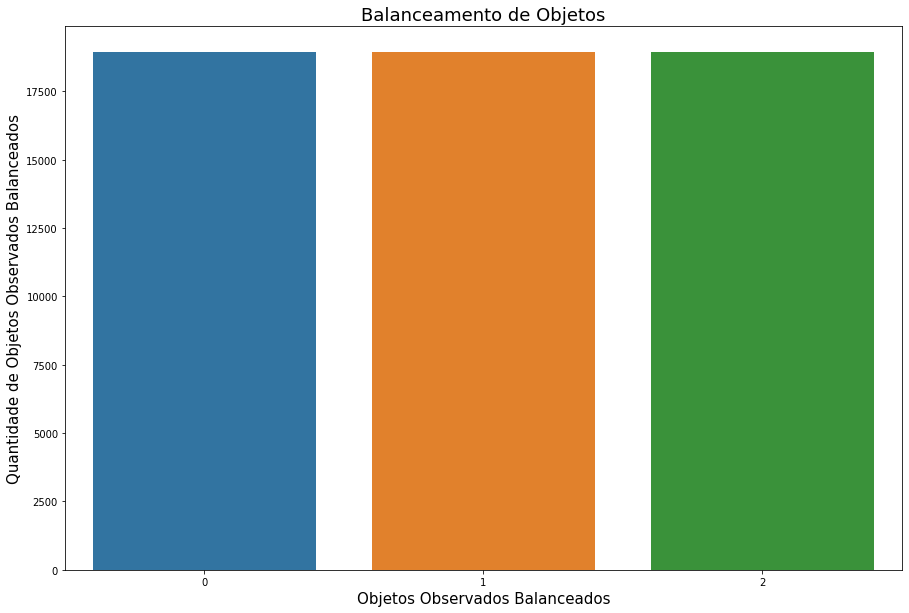

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(y)
plt.xlabel('Objetos Observados Balanceados', fontsize=15)
plt.ylabel('Quantidade de Objetos Observados Balanceados', fontsize=15)
plt.title('Balanceamento de Objetos', fontsize=18)
plt.show()

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([18941, 18941, 18941]))

Podemos ver agora que os dados estão perfeitamente balanceados com a mesma quantidade de dados para as 3 classes.

## Separação da base de treino e testes

Vamos agora fazer a separação das bases de treino e teste. Vamos deixar 75% da base para o treinamento dos modelos e 25% para a base de teste. Para isso vamos usar o método do train_test_split.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



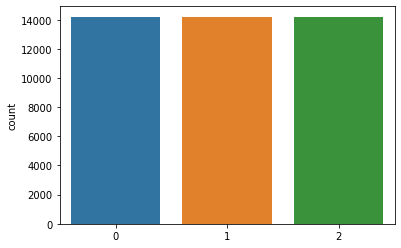

In [ ]:
sns.countplot(y_train)

Podemos ver que usando o método do stratify, obtemos a mesma quantidade de amostras para todas as classes.

# Treinamento dos modelos

Para fazer o treinamento, utilizaremos 5 algoritmos de classificação diferentes. Usaremos os tradicionais SVC e RandomForestClassifier primeiramente e depois utilizaremos as bibliotecas do CatBoostClassifier, XGBClassifier e LGBMClassifier. Ao final do treinamento de cada modelo com a validação cruzada, faremos a verificação do desempenho. Após verificado qual modelo obteve melhor desempenho, vamos utilizar esse modelo para fazer um tunning dos parâmetros e tentar melhorar ainda mais.

In [ ]:
indice = pd.Series(['Galáxia', 'Quasar', 'Estrela'])
colunas = ['Objeto', 'Galáxia', 'Quasar', 'Estrela']

## SVC (Support Vectors Classifier)

In [ ]:
svc = SVC()
svc.fit(x_train, y_train)
pred_svc = svc.predict(x_test)
acc_svc = accuracy_score(y_test, pred_svc)
results_svc = cross_val_score(estimator=svc, X=X, y=y, scoring='accuracy', cv=10)

In [ ]:
print('A Acurácia do modelo SVC foi de {:.2f}% \n'.format(acc_svc*100)) 
print('A média de acurácia da validação cruzada do modelo SVC foi de {:.2f}% \n'.format(results_svc.mean()*100)) 
print('O desvio padrão do da validação cruzada do modelo de SVC foi de {:.4f} \n '.format(results_svc.std())) 
print(classification_report(y_test, pred_svc))

A Acurácia do modelo SVC foi de 96.12% 

A média de acurácia da validação cruzada do modelo SVC foi de 95.98% 

O desvio padrão do da validação cruzada do modelo de SVC foi de 0.0088 
 
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      4735
           1       0.97      0.92      0.94      4736
           2       0.99      1.00      1.00      4735

    accuracy                           0.96     14206
   macro avg       0.96      0.96      0.96     14206
weighted avg       0.96      0.96      0.96     14206



In [ ]:
mc = confusion_matrix(y_test, pred_svc)
fig = px.imshow(mc, text_auto=True,
                x = ['Galáxia', 'Quasar', 'Estrela'],
                y = ['Galáxia', 'Quasar', 'Estrela'])
fig.show()

## Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
pred_rf = rf.predict(x_test)
acc_rf = accuracy_score(y_test, pred_rf)
results_rf = cross_val_score(estimator=rf, scoring='accuracy', X=X, y=y, cv=10)

In [ ]:
print('A Acurácia do modelo Random Forest Classifier foi de {:.2f}% \n'.format(acc_rf*100)) 
print('A média de acurácia da validação cruzada do modelo Random Forest Classifier foi de {:.2f}% \n'.format(results_rf.mean()*100)) 
print('O desvio padrão do da validação cruzada do modelo de Random Forest Classifier foi de {:.4f} \n '.format(results_rf.std())) 
print(classification_report(y_test, pred_rf))

A Acurácia do modelo Random Forest Classifier foi de 97.10% 

A média de acurácia da validação cruzada do modelo Random Forest Classifier foi de 97.04% 

O desvio padrão do da validação cruzada do modelo de Random Forest Classifier foi de 0.0111 
 
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4735
           1       0.96      0.95      0.96      4736
           2       1.00      1.00      1.00      4735

    accuracy                           0.97     14206
   macro avg       0.97      0.97      0.97     14206
weighted avg       0.97      0.97      0.97     14206



In [ ]:
mc = confusion_matrix(y_test, pred_rf)
fig = px.imshow(mc, text_auto=True,
                x = ['Galáxia', 'Quasar', 'Estrela'],
                y = ['Galáxia', 'Quasar', 'Estrela'])
fig.show()

## CatBoost Classifier

In [ ]:
cb = CatBoostClassifier(verbose=False, iterations=25000)
cb.fit(x_train, y_train)
pred_cb = cb.predict(x_test)
acc_cb = accuracy_score(y_test, pred_cb)
results_cb = cross_val_score(estimator=cb, X=X, y=y, scoring='accuracy', cv=10)

In [ ]:
print('A Acurácia do modelo CatBoost Classifier foi de {:.2f}% \n'.format(acc_cb*100)) 
print('A média de acurácia da validação cruzada do modelo CatBoost Classifier foi de {:.2f}% \n'.format(results_cb.mean()*100)) 
print('O desvio padrão do da validação cruzada do modelo de CatBoost Classifier foi de {:.4f} \n '.format(results_cb.std())) 
print(classification_report(y_test, pred_cb))

A Acurácia do modelo CatBoost Classifier foi de 97.23% 

A média de acurácia da validação cruzada do modelo CatBoost Classifier foi de 97.04% 

O desvio padrão do da validação cruzada do modelo de CatBoost Classifier foi de 0.0110 
 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4735
           1       0.97      0.95      0.96      4736
           2       1.00      1.00      1.00      4735

    accuracy                           0.97     14206
   macro avg       0.97      0.97      0.97     14206
weighted avg       0.97      0.97      0.97     14206



In [ ]:
mc = confusion_matrix(y_test, pred_cb)
fig = px.imshow(mc, text_auto=True,
                x = ['Galáxia', 'Quasar', 'Estrela'],
                y = ['Galáxia', 'Quasar', 'Estrela'])
fig.show()

## XGBoost Classifier

In [ ]:
xg = XGBClassifier()
xg.fit(x_train, y_train)
pred_xg = xg.predict(x_test)
acc_xg = accuracy_score(y_test, pred_xg)
results_xg = cross_val_score(estimator=xg, X=X, y=y, scoring='accuracy', cv=10)

In [ ]:
print('A Acurácia do modelo XGBoost Classifier foi de {:.2f}% \n'.format(acc_xg*100)) 
print('A média de acurácia da validação cruzada do modelo XGBoost Classifier foi de {:.2f}% \n'.format(results_xg.mean()*100)) 
print('O desvio padrão do da validação cruzada do modelo de XGBoost Classifier foi de {:.4f} \n '.format(results_xg.std())) 
print(classification_report(y_test, pred_xg))

A Acurácia do modelo XGBoost Classifier foi de 96.49% 

A média de acurácia da validação cruzada do modelo XGBoost Classifier foi de 96.45% 

O desvio padrão do da validação cruzada do modelo de XGBoost Classifier foi de 0.0106 
 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      4735
           1       0.96      0.93      0.95      4736
           2       1.00      1.00      1.00      4735

    accuracy                           0.96     14206
   macro avg       0.97      0.96      0.96     14206
weighted avg       0.97      0.96      0.96     14206



In [ ]:
mc = confusion_matrix(y_test, pred_xg)
fig = px.imshow(mc, text_auto=True,
                x = ['Galáxia', 'Quasar', 'Estrela'],
                y = ['Galáxia', 'Quasar', 'Estrela'])
fig.show()

## LGBM Classifier

In [ ]:
lg = LGBMClassifier()
lg.fit(x_train, y_train)
pred_lg = lg.predict(x_test)
acc_lg = accuracy_score(y_test, pred_lg)
results_lg = cross_val_score(estimator=lg, X=X, y=y, scoring='accuracy', cv=10)

In [ ]:
print('A Acurácia do modelo LGBM Classifier foi de {:.2f}% \n'.format(acc_lg*100)) 
print('A média de acurácia da validação cruzada do modelo LGBM Classifier foi de {:.2f}% \n'.format(results_lg.mean()*100)) 
print('O desvio padrão do da validação cruzada do modelo de LGBM Classifier foi de {:.4f} \n '.format(results_lg.std())) 
print(classification_report(y_test, pred_lg))

A Acurácia do modelo LGBM Classifier foi de 97.08% 

A média de acurácia da validação cruzada do modelo LGBM Classifier foi de 96.94% 

O desvio padrão do da validação cruzada do modelo de LGBM Classifier foi de 0.0104 
 
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4735
           1       0.96      0.95      0.96      4736
           2       1.00      1.00      1.00      4735

    accuracy                           0.97     14206
   macro avg       0.97      0.97      0.97     14206
weighted avg       0.97      0.97      0.97     14206



In [ ]:
mc = confusion_matrix(y_test, pred_lg)
fig = px.imshow(mc, text_auto=True,
                x = ['Galáxia', 'Quasar', 'Estrela'],
                y = ['Galáxia', 'Quasar', 'Estrela'])
fig.show()

## MLP Classifier

In [ ]:
mlp = MLPClassifier(max_iter=22000)
mlp.fit(x_train, y_train)
pred_mlp = mlp.predict(x_test)
acc_mlp = accuracy_score(y_test, pred_mlp)
results_mlp = cross_val_score(X=X, y=y, estimator=mlp, scoring='accuracy', cv=10)

In [ ]:
print('A Acurácia do modelo MLP Classifier foi de {:.2f}% \n'.format(acc_mlp*100)) 
print('A média de acurácia da validação cruzada do modelo MLP Classifier foi de {:.2f}% \n'.format(results_mlp.mean()*100)) 
print('O desvio padrão do da validação cruzada do modelo de MLP Classifier foi de {:.4f} \n '.format(results_mlp.std())) 
print(classification_report(y_test, pred_mlp))

A Acurácia do modelo MLP Classifier foi de 96.99% 

A média de acurácia da validação cruzada do modelo MLP Classifier foi de 96.86% 

O desvio padrão do da validação cruzada do modelo de MLP Classifier foi de 0.0088 
 
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4735
           1       0.96      0.95      0.95      4736
           2       1.00      1.00      1.00      4735

    accuracy                           0.97     14206
   macro avg       0.97      0.97      0.97     14206
weighted avg       0.97      0.97      0.97     14206



In [ ]:
mc = confusion_matrix(y_test, pred_mlp)
fig = px.imshow(mc, text_auto=True,
                x = ['Galáxia', 'Quasar', 'Estrela'],
                y = ['Galáxia', 'Quasar', 'Estrela'])
fig.show()